In [1]:
%autosave 60 

Autosaving every 60 seconds


In [2]:
#default_exp classification.dataset

In [3]:
import fastai; print(fastai.__version__)

1.0.59.dev0


In [4]:
#export
from fastai.vision import *

### databunch

In [94]:
#export 
class ImageClassificationData:
    "Creates image classification dataset from fastai datablock API"
    def __init__(self,PATH,IMAGES,LABELS,TRAIN,VALID,TEST,
                 sample_size,bs,size,**dl_kwargs):
        # input params
        self.path, self.sample_size, self.bs, self.size  = \
        PATH, sample_size, bs, size
#         self.label_cls = partial(MultiCategoryList, label_delim=";") if is_multilabel else CategoryList
        self.VALID, self.TEST = VALID, TEST
        self.dl_kwargs = dl_kwargs
        
        # read training
        self.train_df = pd.read_csv(self.path/TRAIN, header=None)        
        if sample_size: self.train_df = self.train_df.sample(sample_size)
    
        # read validation and test
        if (VALID is not None) and (type(VALID) is str): 
            self.valid_file = True
        else:
            self.valid_file = False
        if self.valid_file: self.valid_df = pd.read_csv(self.path/VALID, header=None)
        if TEST is not None: self.test_df = pd.read_csv(self.path/TEST, header=None)
        
        # read labels
        self.labels_df = pd.read_csv(self.path/LABELS)
        self.labels_df.iloc[:,1] = self.labels_df.iloc[:,1].apply(lambda o: array(eval(o), dtype=np.float16))
        
        # image folder
        self.path_img = self.path/IMAGES
            
    def get_data(self):        
        if self.valid_file: 
            self.train_valid_df = pd.concat([self.train_df, self.valid_df])
            self.train_valid_df.columns = ["images"]
            self.train_valid_df["is_valid"] = len(self.train_df)*[False] + len(self.valid_df)*[True]
        else:
            self.train_valid_df = self.train_df
        
#         import pdb; pdb.set_trace()
        # get
        il = ImageList.from_df(self.train_valid_df, self.path_img) 
        # split
        if self.valid_file: ill = il.split_from_df("is_valid") 
        else: ill = il.split_by_rand_pct(ifnone(self.VALID, 0.2)) 
        # label
        labels_dict = dict(zip(self.labels_df.iloc[:,0], self.labels_df.iloc[:,1]))
        
        ll = ill.label_from_func(lambda o: labels_dict[Path(o).name], label_cls=FloatList)
        # databunch    
        data = (ll.transform(get_transforms(),
                             size=self.size,
                             tfm_y=False,
                             resize_method=ResizeMethod.SQUISH)
                    .databunch(bs=self.bs, **self.dl_kwargs))
        # test
        if self.TEST:
            il = ImageList.from_df(self.test_df, self.path_img) # get
            data.add_test(il, tfm_y=False)
        return data
        
    def __repr__(self):
        return f"""___repr__"""
    
    def __str__(self):
        return f"""___str___"""

### `get_data`

In [95]:
# # test data creation - multilabel
# PATH = Path("/home/turgutluk/data/steel/strategy4/")
# IMAGES = "images"
# LABELS = "labels_df.csv"
# is_multilabel, sample_size, bs, size = True, None, 16, 224
# TRAIN, VALID, TEST = "train_fold0.txt", "valid_fold0.txt", "test.txt"
# ssdata = ImageClassificationData(PATH,IMAGES,LABELS,TRAIN,VALID,TEST,is_multilabel,sample_size,bs,size)
# data = ssdata.get_data(); data

In [96]:
# test data creation - multilabel
PATH = Path("/home/turgutluk/data/hemorrhage/strategy1/")
IMAGES = "images"
LABELS = "labels_df_v2.csv"
is_multilabel, sample_size, bs, size = True, None, 16, 512
TRAIN, VALID, TEST = "train_fold0.csv", "valid_fold0.csv", None
ssdata = ImageClassificationData(PATH,IMAGES,LABELS,TRAIN,VALID,TEST,sample_size,bs,size)
data = ssdata.get_data(); data

ImageDataBunch;

Train: LabelList (477721 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: FloatList
[1. 0. 0. 0. 1. 0.],[0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0.]
Path: /home/turgutluk/data/hemorrhage/strategy1/images;

Valid: LabelList (117873 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: FloatList
[0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0.]
Path: /home/turgutluk/data/hemorrhage/strategy1/images;

Test: None

In [97]:
data.train_ds[3]

(Image (3, 512, 512), FloatItem [0. 0. 0. 0. 0. 0.])

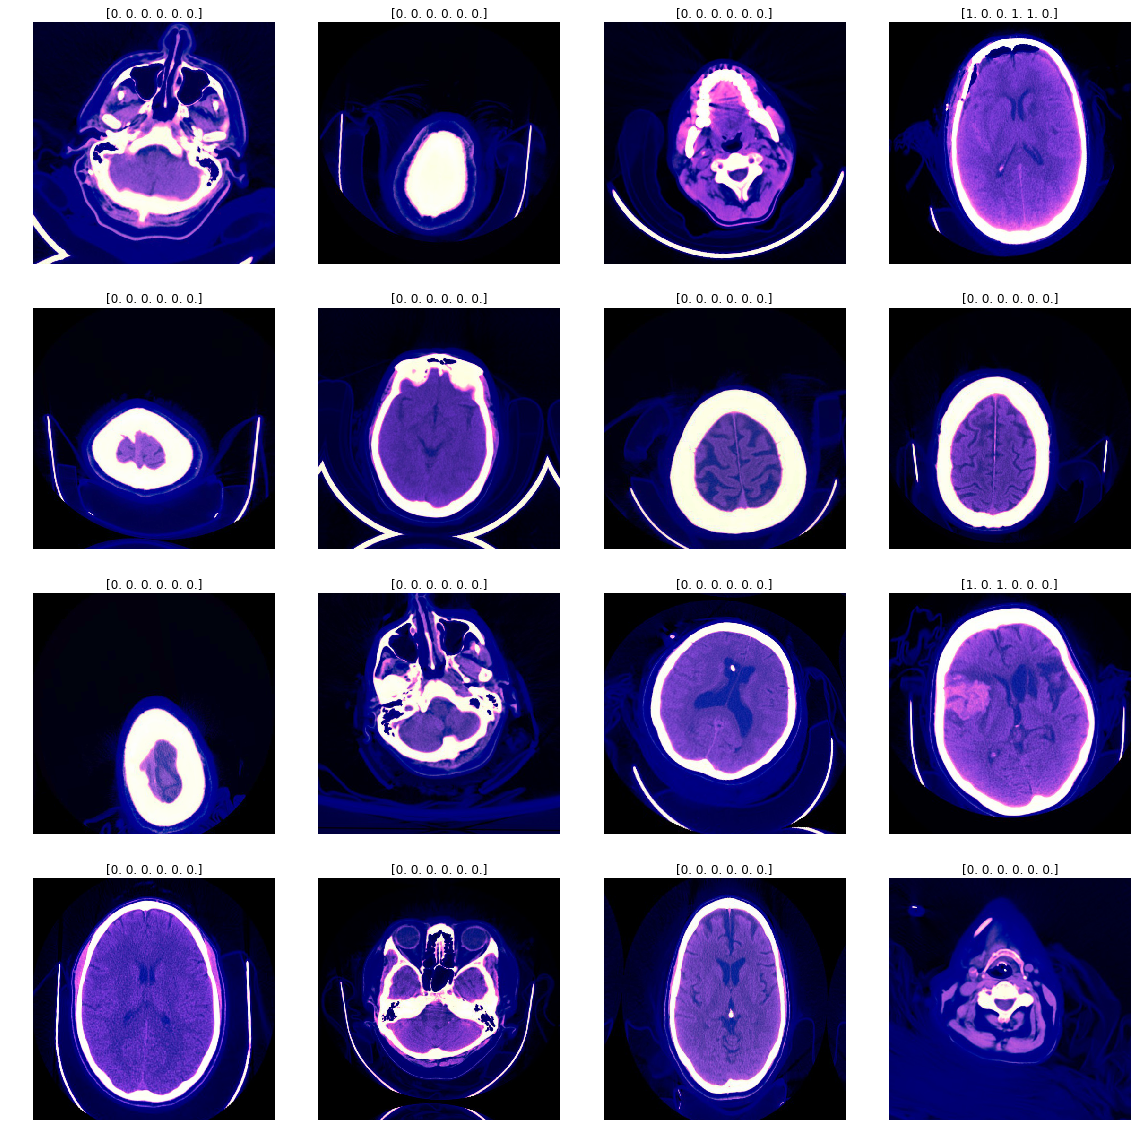

In [98]:
data.show_batch()

In [99]:
xb,yb=data.one_batch()

In [100]:
yb

tensor([[1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

### export

In [80]:
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_script.ipynb.
Converted 02_scheduler.ipynb.
Converted 03_callbacks.ipynb.
Converted 04_optimizers_optimizers.ipynb.
Converted 10_segmentation_dataset.ipynb.
Converted 11_segmentation_losses_mulitlabel.ipynb.
Converted 11b_segmentation_losses_binary.ipynb.
Converted 12_segmentation_metrics.ipynb.
Converted 13_segmentation_models.ipynb.
Converted 14_segmentation_postprocess.ipynb.
Converted 15_segmentation_tta.ipynb.
Converted 16_segmentation_utils.ipynb.
Converted 20_classification_dataset.ipynb.
Converted 21_classification_losses.ipynb.
Converted 23_classification_models.ipynb.
Converted classification_training.ipynb.
Converted segmentation_training.ipynb.


### fin